In [2]:
# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


In [62]:
# Librerías necesarias.
import pandas as pd
import glob
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from matplotlib.pyplot import figure


# Scaling.

from sklearn.preprocessing import MinMaxScaler


In [63]:
files_names = []
for name in glob.glob("datos/precios/Precio_Bolsa_Nacional*"):
    files_names.append(name)


# ORDENAR LOS NOMBRES DE LOS FICHEROS
files_names.sort()

In [5]:
serie_precios_energia = pd.DataFrame(columns = ['Fecha',"Precio_Promedio"])

for name in files_names:
    excel_file = pd.read_excel(name, skiprows=3)
    total_rows = excel_file.shape[0]
    for index in range (0,total_rows):
        date = excel_file.iloc[index,0]
        avg = excel_file.iloc[:,1:25].loc[index].mean()
        data = {'Fecha': [date],'Precio_Promedio': [avg]}
        df = pd.DataFrame(data)
        serie_precios_energia = pd.concat([serie_precios_energia, df], ignore_index=True)
        
# Limpieza de promedios nulos del dataset.
serie_precios_energia = serie_precios_energia.dropna()

#Conversion de la fecha
serie_precios_energia["Fecha"] = pd.to_datetime(serie_precios_energia["Fecha"])

serie_precios_energia.head(30)

,Fecha,Precio_Promedio
0,1995-07-20,1.409435
1,1995-07-21,4.924333
2,1995-07-22,1.269500
3,1995-07-23,0.953083
4,1995-07-24,4.305917
5,1995-07-25,1.149167
6,1995-07-26,1.108625
7,1995-07-27,0.585958
8,1995-07-28,0.499792
9,1995-07-29,0.927667


In [6]:
serie_precios_energia.describe()

,Precio_Promedio
count,8381.000000
mean,107.261842
std,128.455338
min,0.499792
25%,45.975272
50%,74.657275
75%,132.116958
max,1942.692800


In [7]:
serie_precios_energia = serie_precios_energia.sort_values(by=['Fecha'])

/home/paul96/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


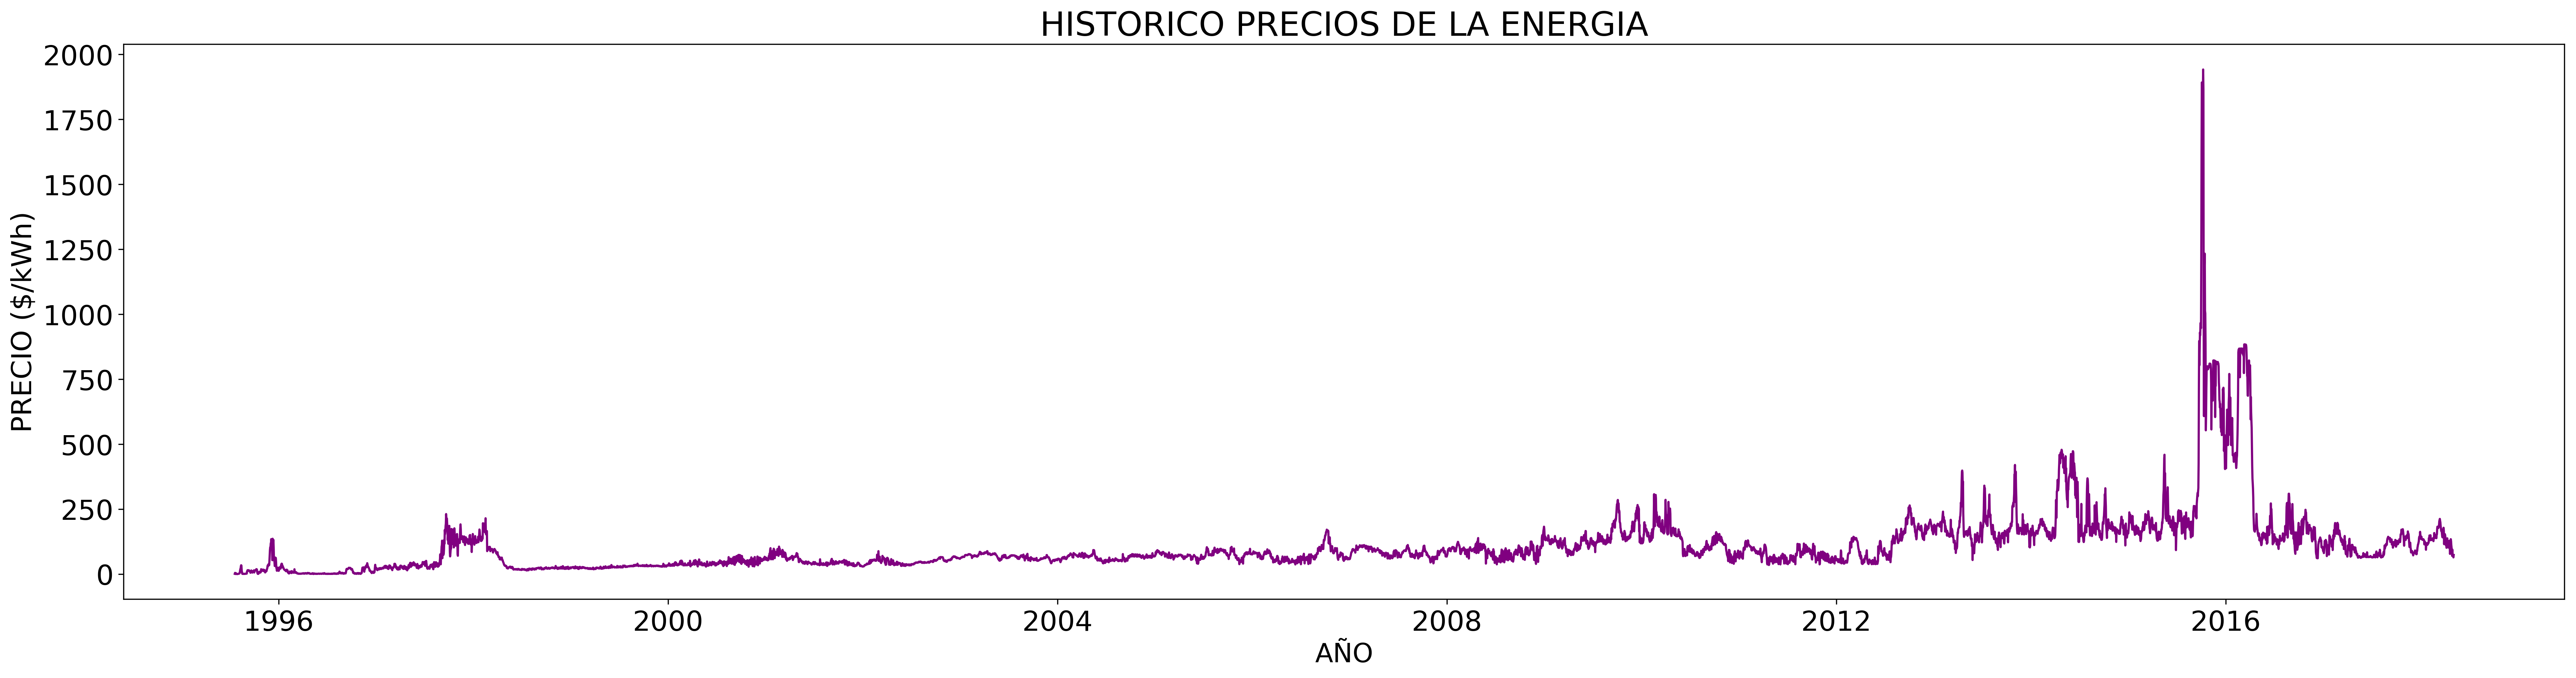

In [8]:
figure(num=None, figsize=(30,7), dpi=320, facecolor='w', edgecolor='g')
plt.rcParams.update({'font.size': 19})
plt.plot(serie_precios_energia["Fecha"], serie_precios_energia["Precio_Promedio"], color='purple')
plt.title('HISTORICO PRECIOS DE LA ENERGIA')
plt.xlabel('AÑO', fontsize=18)
plt.ylabel('PRECIO ($/kWh)')
plt.show()

In [10]:
# PROCESO PARA LLEVAR EL HISTORICO DE PRECIOS A LA MISMA ESCALA DADO EL IPC.

route = './datos/precios/1.2.5.IPC_Serie_variaciones.xlsx';
# Cargamos el fichero con los datos del IPC.
IPC = pd.read_excel(route, skiprows=12)

IPC = IPC.iloc[:,0:2] 
IPC = IPC.iloc[:-6] #No nos interesa las ultima 6 columnas correspondientes a los creditos
IPC.columns = ['Fecha_Formato_Mes', 'IPC']

#Convierto las fechas a formato YYYY-MM

IPC['Fecha_Formato_Mes'] = IPC['Fecha_Formato_Mes'].astype(str)
IPC['Fecha_Formato_Mes'] = IPC['Fecha_Formato_Mes'].apply(lambda x: x[:4] + '-' + x[4:])
IPC['Fecha_Formato_Mes'] = pd.to_datetime(IPC['Fecha_Formato_Mes']).dt.to_period('M')


serie_precios_energia['Fecha_Formato_Mes'] = pd.to_datetime(serie_precios_energia['Fecha'].astype(str)).dt.to_period('M')

serie_energia_normalizada = pd.merge(serie_precios_energia , IPC, on="Fecha_Formato_Mes", how="left")

serie_energia_normalizada.head(20)

,Fecha,Precio_Promedio,Fecha_Formato_Mes,IPC
0,1995-07-20,1.409435,1995-07,20.93
1,1995-07-21,4.924333,1995-07,20.93
2,1995-07-22,1.269500,1995-07,20.93
3,1995-07-23,0.953083,1995-07,20.93
4,1995-07-24,4.305917,1995-07,20.93
5,1995-07-25,1.149167,1995-07,20.93
6,1995-07-26,1.108625,1995-07,20.93
7,1995-07-27,0.585958,1995-07,20.93
8,1995-07-28,0.499792,1995-07,20.93
9,1995-07-29,0.927667,1995-07,20.93


### Valor Presente del valor de la energía de acuerdo al IPC

* Es necesario ajustar por IPC para llevar los precios a una moneda constante, para realizar esto realizamos una regla de tres, teniendo en cuenta un ipc base en este caso se trabajara con el IPC del 2018 - 12.

* Para esto aplicamos la siguiente regla de tres:

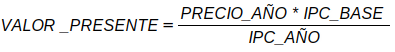

In [11]:
IPC_BASE = 100 # 2018 - 12 PRESENTA IPC DE 100
serie_energia_normalizada['Valor_Presente'] = serie_energia_normalizada['Precio_Promedio']*(IPC_BASE/serie_energia_normalizada['IPC'])

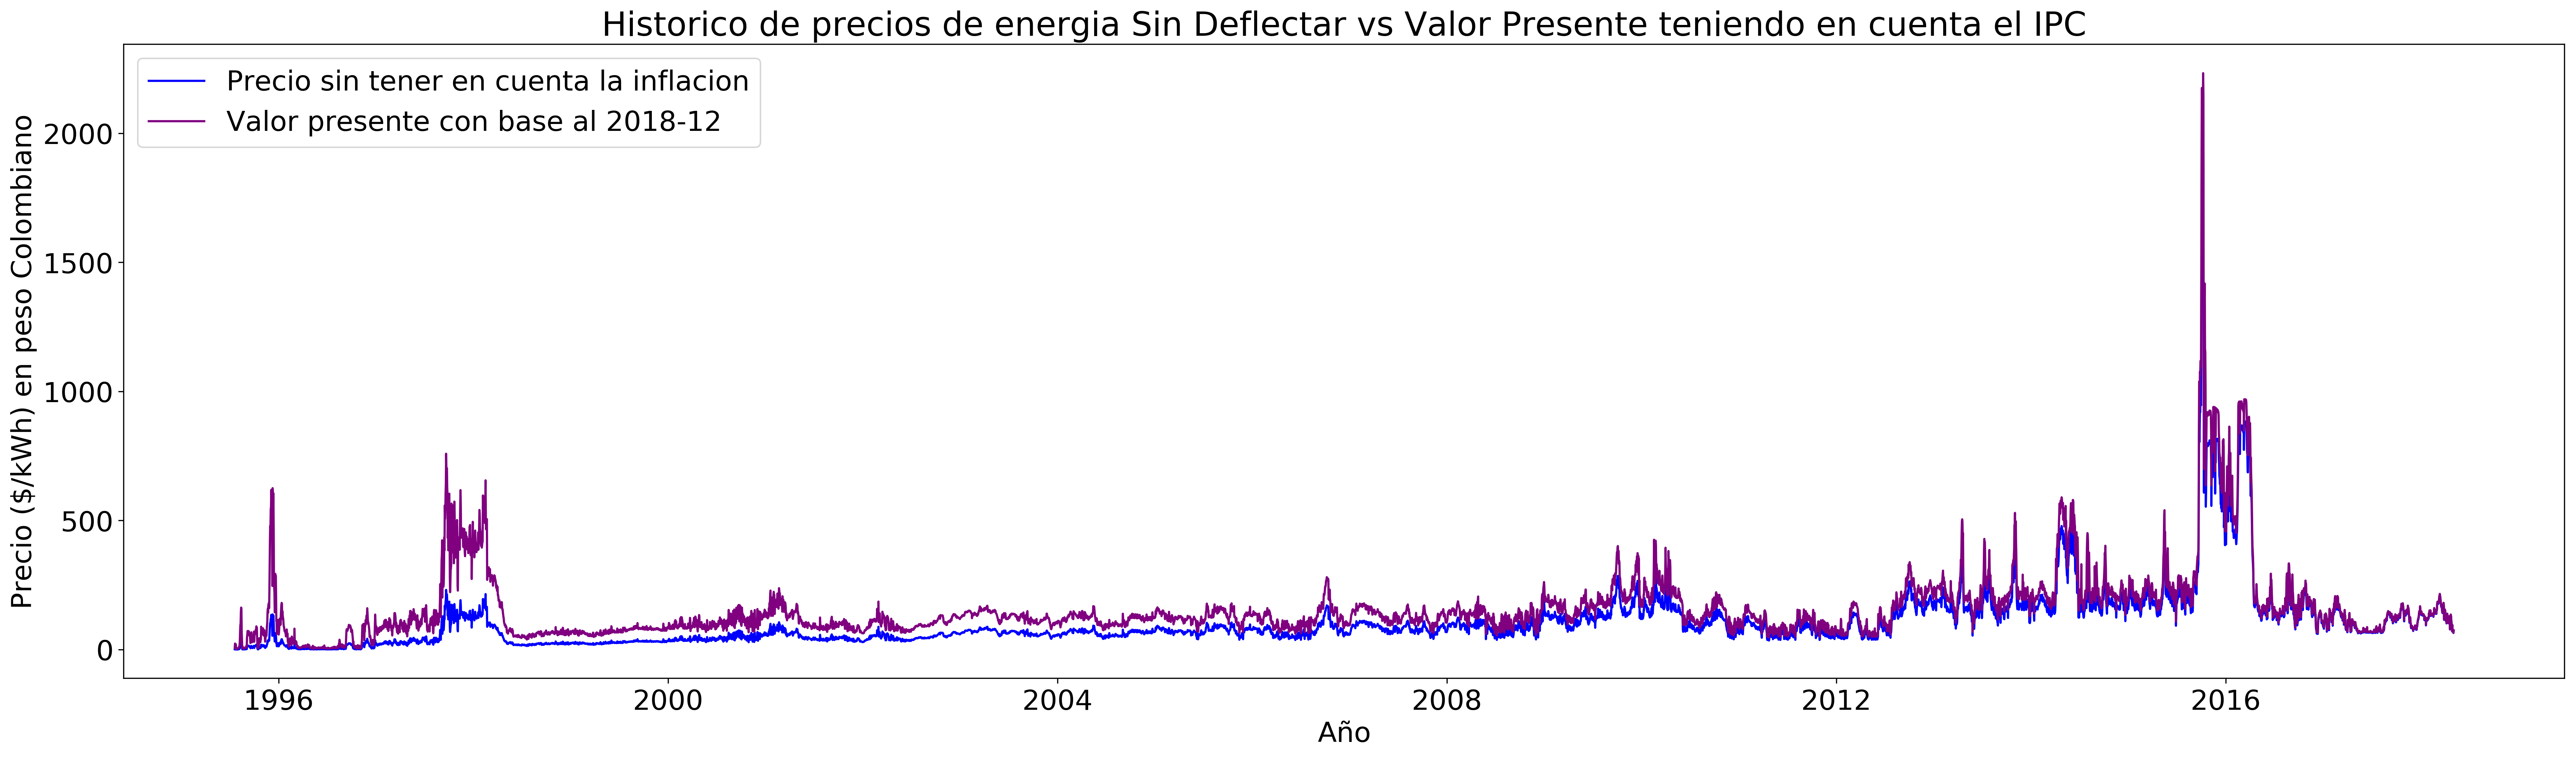

In [12]:
figure(num=None, figsize=(30,8), dpi=320, facecolor='w', edgecolor='g')
plt.rcParams.update({'font.size': 19})
plt.title('Historico de precios de energia Sin Deflectar vs Valor Presente teniendo en cuenta el IPC')
plt.xlabel('Año')
plt.ylabel('Precio ($/kWh) en peso Colombiano')
plt.plot(serie_energia_normalizada['Fecha'], serie_energia_normalizada['Precio_Promedio'],label="Precio sin tener en cuenta la inflacion", color='blue')
plt.plot(serie_energia_normalizada['Fecha'], serie_energia_normalizada['Valor_Presente'],label="Valor presente con base al 2018-12", color='purple')
plt.legend()
plt.show()

De acuerdo a la gráfica podemos ver que al normalizar el historico de precios de energía, los precios anteriores al 2018 - 12 al ajustarse a una moneda constante por la inflación se aumentan un poco

### Transformación de funciones .

Se procede a hacer transformaciones de los datos del historico de precios de la energía y de acuerdo al pronóstico del modelo se elige el mejor.

Las siguientes funciones se tendrán en cuenta para la transformacion de precios de la energia.

#### $y = \sqrt(x)$
#### $y = \ln(x)$
#### $y = \sqrt[3]{x}$
#### $y = x^{2}$

In [13]:
dataset_precios_energia = serie_energia_normalizada[['Fecha', 'Fecha_Formato_Mes', 'Valor_Presente']].copy()

# Aplicamos las transformaciones

dataset_precios_energia['raiz_cuadrada'] = np.sqrt(dataset_precios_energia['Valor_Presente'])
dataset_precios_energia['logaritmo_natural'] = np.log(dataset_precios_energia['Valor_Presente'])
dataset_precios_energia['raiz_cubica'] = np.cbrt(dataset_precios_energia['Valor_Presente'])
dataset_precios_energia['x_al_cuadrado'] = np.square(dataset_precios_energia['Valor_Presente'])

dataset_precios_energia.head(20)

,Fecha,Fecha_Formato_Mes,Valor_Presente,raiz_cuadrada,logaritmo_natural,raiz_cubica,x_al_cuadrado
0,1995-07-20,1995-07,6.734041,2.595003,1.907175,1.888391,45.347308
1,1995-07-21,1995-07,23.527632,4.850529,3.158176,2.865449,553.549458
2,1995-07-22,1995-07,6.065456,2.462815,1.802610,1.823705,36.789760
3,1995-07-23,1995-07,4.553671,2.133933,1.515934,1.657501,20.735919
4,1995-07-24,1995-07,20.572942,4.535740,3.023977,2.740094,423.245924
5,1995-07-25,1995-07,5.490524,2.343187,1.703024,1.764160,30.145853
6,1995-07-26,1995-07,5.296823,2.301483,1.667107,1.743165,28.056331
7,1995-07-27,1995-07,2.799610,1.673203,1.029480,1.409394,7.837815
8,1995-07-28,1995-07,2.387920,1.545290,0.870423,1.336616,5.702162
9,1995-07-29,1995-07,4.432234,2.105287,1.488904,1.642634,19.644702


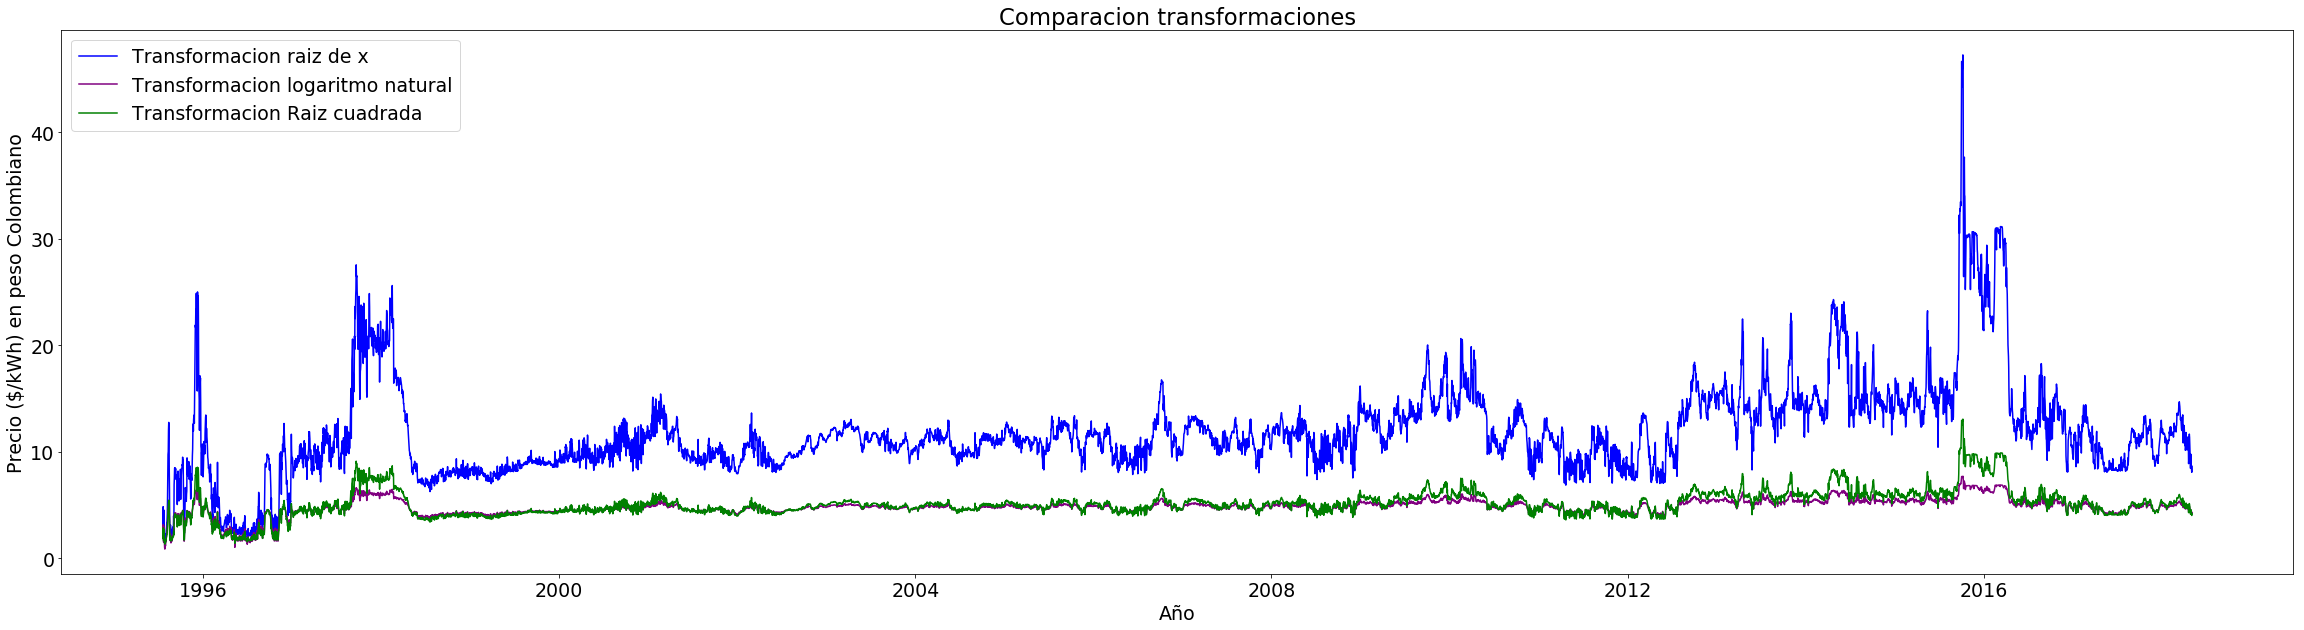

In [14]:
plt.figure(figsize=(40,10))
plt.rcParams.update({'font.size': 19})
plt.title('Comparacion transformaciones')
plt.xlabel('Año')
plt.ylabel('Precio ($/kWh) en peso Colombiano')
plt.plot(dataset_precios_energia['Fecha'], dataset_precios_energia['raiz_cuadrada'],label="Transformacion raiz de x", color='blue')
plt.plot(dataset_precios_energia['Fecha'], dataset_precios_energia['logaritmo_natural'],label="Transformacion logaritmo natural", color='purple')
plt.plot(dataset_precios_energia['Fecha'], dataset_precios_energia['raiz_cubica'],label="Transformacion Raiz cuadrada", color='green')
plt.legend()
plt.show()


In [15]:
def inversa(values, nombre_transformacion):
    if (nombre_transformacion ==  "logaritmo_natural"):
        return np.exp(values)
    elif (nombre_transformacion == "raiz_cuadrada"):
        return np.square(values)
    elif (nombre_transformacion == "raiz_cubica"):
        return np.cbrt(values)
    elif (nombre_transformacion == "x_al_cuadrado"):
        return np.sqrt(values)

In [16]:
dataset_precios_energia.describe()

,Valor_Presente,raiz_cuadrada,logaritmo_natural,raiz_cubica,x_al_cuadrado
count,8381.000000,8381.000000,8381.000000,8381.000000,8.381000e+03
mean,159.655650,11.855320,4.818137,5.128328,4.741942e+04
std,148.094941,4.371422,0.740310,1.220036,1.786975e+05
min,2.387920,1.545290,0.870423,1.336616,5.702162e+00
25%,89.671334,9.469495,4.496151,4.475943,8.040948e+03
50%,125.273064,11.192545,4.830496,5.003638,1.569334e+04
75%,176.910590,13.300774,5.175644,5.613727,3.129736e+04
max,2233.493676,47.259853,7.711322,13.071585,4.988494e+06


In [17]:
class Adaline:
    def __init__(self,
                 learning_rate=0.001, # tasa de aprendizaje
                 max_epochs=100,      # número máximo de iteraciones sobre el set de datos
                 shuffle=False,       # mezcla patrones para aprendizaje online
                 random_state=None,   #
                 warm_start=False):   #

        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):

        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()

        if self.random_state is not None:
            np.random.RandomState(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(-1, 1, X.shape[1])

        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(-1, 1, 1)

        errors2 = []
        forecasts = []

        for epoch in range(self.max_epochs):

            if self.shuffle is True:
                n = list(range(X.shape[0]))
                np.random.shuffle(n)
                X = X[n,:]
                d = d[n]

            for i in range(X.shape[0]):
                u = np.dot(X[i,:], self.coef_) + self.intercept_
                e = (d[i] - u)[0]
                self.coef_ += 2 * self.learning_rate * e * X[i,:]
                self.intercept_ += 2 * self.learning_rate * e
                errors2.append(e**2)
                forecasts.append(u)

        return errors2, forecasts

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        u = np.dot(X, self.coef_) + self.intercept_
        return u

### Obtención de dataset de entrenamiento y de predicción.

#### Para la obtención de dataset de entrenamiento y predicción, se parte de la siguiente manera, se quiere probar el modelo para predecir los últimos 7 días.

* Entrenamiento: Se toma todo el conjunto a excepción de los 7 dias.
* Predicción: Se toman los últimos 7 días.

In [18]:
train_dataset = dataset_precios_energia.iloc[:-7]
predict_dataset = dataset_precios_energia.tail(7)
predict_dataset = predict_dataset.reset_index(drop=True)

In [236]:
predict_dataset

,Fecha,Fecha_Formato_Mes,Valor_Presente,raiz_cuadrada,logaritmo_natural,raiz_cubica,x_al_cuadrado
0,2018-04-29,2018-04,71.372985,8.448253,4.267919,4.148056,5094.102969
1,2018-04-30,2018-04,95.731087,9.784226,4.561543,4.574578,9164.440924
2,2018-05-01,2018-05,72.273826,8.501401,4.280462,4.165435,5223.505945
3,2018-05-02,2018-05,77.021421,8.776185,4.344084,4.254715,5932.299283
4,2018-05-03,2018-05,71.751057,8.470600,4.273203,4.155367,5148.214163
5,2018-05-04,2018-05,65.258289,8.078260,4.178353,4.026044,4258.644322
6,2018-05-05,2018-05,74.598714,8.637055,4.312123,4.209629,5564.968110


In [76]:
transformaciones = ['Valor_Presente', 'raiz_cuadrada', 'logaritmo_natural', 'raiz_cubica', 'x_al_cuadrado']


scale = dict()

for transformacion in transformaciones:
    scaler = MinMaxScaler() 
    data = np.asarray(train_dataset[transformacion]).reshape(-1,1)
    scaler.fit(data)
    d = scaler.transform(data).ravel()
    scale[transformacion] = scaler

In [74]:

retardos_posibles = range(2,11) # Retardos entre 2 y 10 dias
tasas_de_aprendizaje_posibles = np.arange(0.005, 0.1, 0.005)
momentum_posibles = np.arange(0.00000, 0.0001,0.000025)
tasa_aprendizaje_optima = None
retardo_optimo = None
momentum_optimo = 0


resultado_modelo = pd.DataFrame(columns = ["Transformacion",
                                           "Error_Pronostico",
                                           "Error_Entrenamiento",
                                           "Retardos",
                                           "Momentum",
                                           "Tasa_Aprendizaje",
                                           "Pronosticos"])


# Proceso para obtener el mejor modelo.
for transformacion in transformaciones:
    # Obtengo a D del dataset de prediccion
    scaler = scale[transformacion]
    d = scaler.transform(np.asarray(train_dataset[transformacion]).reshape(-1,1))
    
    for L in retardos_posibles:
        for tasa_de_aprendizaje in tasas_de_aprendizaje_posibles:
            for momentum in momentum_posibles:
                X = []
                ##
                ## Forma la matriz X
                ##    
                for t in range(L, len(d)):
                    X.append(d[t-L:t].copy())
                    
                #Se entrena el modelo
                adaline = Adaline(
                    learning_rate=tasa_de_aprendizaje, 
                    momentum = momentum,  
                    shuffle=True, # Iniciar con pesos aleatorios.       
                    random_state=123,
                    max_epochs=1,
                    warm_start=False)    
                errors2, forecasts = adaline.fit(X, d[L:])
                
                P = [] # Lista de pronosticos.
            
                 # Generacion de pronosticos para los proximos 7 dias.
                for i in range(7):
                    u = adaline.predict(X[-1]) # pronostico siguiente dia.
                    next_X = np.append(X[-1][1:L], [u]) # Agregar fila a la matriz X
                    X = np.concatenate( ( X, [next_X] ), axis=0) # Agregar fila a la matriz X
                    P.append(u[0]) # Agregamos el pronostico.
                
                # Ahora invertimos el feature scaling que se le realizo al modelo
                P = scaler.inverse_transform(np.asarray(P).reshape(-1,1)).ravel() # Para los 7 dias.
                forecasts = scaler.inverse_transform(np.asarray(forecasts).reshape(-1,1)).ravel()
                
                
                # Obtenemos la inversa de la transformacion de la funcion para proceder al calculo del error.
                if(transformacion != 'Valor_Presente' ):
                    P = inversa(P, transformacion)
                    forecasts = inversa(forecasts, transformacion)
                
                
                

SyntaxError: invalid syntax (<ipython-input-74-2bdb9185cf25>, line 26)